In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Don't allow any numerical fault. More info: https://numpy.org/doc/stable/user/misc.html
np.seterr(all="raise")

mpl.rcParams["figure.figsize"] = (40, 5)

from typeguard import typechecked

from numpy import datetime64
from numpy.typing import NDArray
from pandas import Timestamp, Timedelta
from pvlib import location
from pytz import timezone

from lib.utils import (
    get_irradiance,
    integrate,
    open_forecast_files,
    plot_radiation_and_irradiance,
    mae,
    rmse,
)
from lib.boat_model import Boat, Other
from lib.panel_model import Panel
from lib.mppt_model import MPPT
from lib.battery_model import Battery
from lib.esc_model import ESC
from lib.motor_model import Motor
from lib.transmission_model import Transmission
from lib.hull_model import Hull
from lib.energy_controller_model import EnergyController, ConstantPowerController
from lib.boat_data import (
    BoatInputData,
    BoatInputDataSet,
    BoatOutputData,
)
from lib.event_model import Event, ControlledBoat
from lib.event_data import EventInputData, EventResultData, RaceStatus, FixedLapsGoal
from lib.competition_model import Competition, CompetitionResult


In [2]:
df = pd.read_csv("models/2020/boat_data_1s.csv")
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")
df


,Unnamed: 0,batt_i,batt_ii,batt_io,batt_pi,batt_po,batt_p,batt_v,bat1_v,bat2_v,...,prop_torq,solcast_AirTemp,solcast_energy,solcast_poa,trans_p_in,trans_p_out,trans_rpmi,trans_rpmo,trans_torqi,trans_torqo
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-29 14:56:53,0,NaN,0.0,NaN,0.0,NaN,NaN,38.656250,12.929688,12.625000,...,NaN,27.8,2371.152789,817.383464,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-29 14:56:54,1,NaN,0.0,NaN,0.0,NaN,NaN,38.648438,12.929688,12.617188,...,NaN,27.8,2371.152789,817.383464,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-29 14:56:55,2,NaN,0.0,NaN,0.0,NaN,NaN,38.648438,12.929688,12.617188,...,NaN,27.8,2371.152789,817.383464,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-29 14:56:56,3,NaN,0.0,NaN,0.0,NaN,NaN,38.648438,12.929688,12.617188,...,NaN,27.8,2371.152789,817.383464,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-29 14:56:57,4,NaN,0.0,NaN,0.0,NaN,NaN,38.648438,12.929688,12.617188,...,NaN,27.8,2371.152789,817.383464,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-02 16:25:25,350912,NaN,NaN,0.0,NaN,0.0,NaN,37.419838,12.687500,12.294837,...,NaN,26.0,23891.110969,238.000000,NaN,NaN,0.0,0.0,NaN,NaN
2020-02-02 16:25:26,350913,NaN,NaN,0.0,NaN,0.0,NaN,37.421875,12.687500,12.296875,...,NaN,26.0,23891.110969,238.000000,NaN,NaN,0.0,0.0,NaN,NaN
2020-02-02 16:25:27,350914,NaN,NaN,0.0,NaN,0.0,NaN,37.418270,12.687500,12.293269,...,NaN,26.0,23891.110969,238.000000,NaN,NaN,0.0,0.0,NaN,NaN


In [3]:
# Select the input data
input_data = BoatInputDataSet(
    {
        "time": df.index.to_numpy(),
        # "poa": df["solcast_poa"].to_numpy(),
        "poa": df["mppt_p_in"].fillna(0).to_numpy(),
    }
)


In [4]:
# Create the competition
site = location.Location(
    latitude=-26.243602,
    longitude=-48.6417668,
    tz="America/Sao_Paulo",
    altitude=0,
    name="São Francisco do Sul",
)

tzinfo = timezone(site.tz)
competition = Competition(
    name="DSB 2020 - São Francisco do Sul",
    events=[
        # Event(
        #     EventInputData(
        #         name="Short Race 1",
        #         description="Prova Curta",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=np.float64(786.73),
        #             event_duration=Timedelta(hours=1),
        #         ),
        #         start=Timestamp(
        #             year=2020,
        #             month=1,
        #             day=29,
        #             hour=13,
        #             minute=51,
        #             second=59,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #         end=Timestamp(
        #             year=2020,
        #             month=1,
        #             day=29,
        #             hour=15,
        #             minute=5,
        #             second=32,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Long Race 1",
        #         description="Prova longa",
        #         goal=FixedLapsGoal(
        #             total_laps=3 * 2,
        #             lap_distance=np.float64(7081.987),
        #             event_duration=Timedelta(hours=5),
        #         ),
        #         start=Timestamp(
        #             year=2020,
        #             month=1,
        #             day=30,
        #             hour=11,
        #             minute=16,
        #             second=45,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #         end=Timestamp(
        #             year=2020,
        #             month=1,
        #             day=30,
        #             hour=14,
        #             minute=55,
        #             second=30,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Relay Race",
        #         description="Prova de revezamento de pilotos",
        #         goal=FixedLapsGoal(
        #             total_laps=2,
        #             lap_distance=np.float64(812.19),
        #             event_duration=Timedelta(hours=3),
        #         ),
        #         start=Timestamp(
        #             year=2020,
        #             month=1,
        #             day=31,
        #             hour=11,
        #             minute=23,
        #             second=23,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #         end=Timestamp(
        #             year=2020,
        #             month=1,
        #             day=31,
        #             hour=13,
        #             minute=27,
        #             second=23,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Short Race 2",
        #         description="Prova curta",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=np.float64(4678.39),
        #             event_duration=Timedelta(hours=2),
        #         ),
        #         start=Timestamp(
        #             year=2020,
        #             month=2,
        #             day=1,
        #             hour=10,
        #             minute=15,
        #             second=15,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #         end=Timestamp(
        #             year=2020,
        #             month=2,
        #             day=1,
        #             hour=11,
        #             minute=37,
        #             second=28,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Short Race 3",
        #         description="Prova curta",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=np.float64(4678.39),
        #             event_duration=Timedelta(hours=1),
        #         ),
        #         start=Timestamp(
        #             year=2020,
        #             month=2,
        #             day=1,
        #             hour=13,
        #             minute=15,
        #             second=9,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #         end=Timestamp(
        #             year=2020,
        #             month=2,
        #             day=1,
        #             hour=13,
        #             minute=37,
        #             second=28,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #     )
        # ),
        Event(
            EventInputData(
                name="Test region 1",
                description="Region with good data",
                goal=FixedLapsGoal(
                    total_laps=1,
                    lap_distance=np.float64(1000),
                    event_duration=Timedelta(minutes=30),
                ),
                start = pd.Timestamp(year=2020, month=1, day=31, hour=12, minute=9, second=0, tzinfo=tzinfo).tz_convert(None),
                end = pd.Timestamp(year=2020, month=1, day=31, hour=12, minute=13, second=0, tzinfo=tzinfo).tz_convert(None),
            )
        ),
        # Event(
        #     EventInputData(
        #         name="Sprint Race",
        #         description="Prova de arrancada",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=np.float64(1057.03),
        #             event_duration=Timedelta(minutes=15),
        #         ),
        #         start=Timestamp(
        #             year=2020,
        #             month=2,
        #             day=2,
        #             hour=11,
        #             minute=58,
        #             second=27,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #         end=Timestamp(
        #             year=2020,
        #             month=2,
        #             day=2,
        #             hour=11,
        #             minute=59,
        #             second=9,
        #             tzinfo=tzinfo,
        #         ).tz_convert(None),
        #     )
        # ),
    ],
)


In [5]:
import numpy as np
from dataclasses import dataclass
import bisect

def interpolate_lut(lookup_table: dict, value: np.float64):
    sorted_keys = sorted(lookup_table.keys())

    # Check if value is below the lowest key
    if value < sorted_keys[0]:
        return lookup_table[sorted_keys[0]]

    # Check if value is above the highest key
    if value > sorted_keys[-1]:
        return lookup_table[sorted_keys[-1]]

    # Find the nearest lower and higher keys using bisect_left
    index = bisect.bisect_left(sorted_keys, value) # type: ignore
    if sorted_keys[index] == value:
        return lookup_table[value]

    low = sorted_keys[index - 1]
    high = sorted_keys[index]
    low_value = lookup_table[low]
    high_value = lookup_table[high]
    interpolation_ratio = (value - low) / (high - low)
    interpolated_value = low_value + (high_value - low_value) * interpolation_ratio

    return interpolated_value


class ME9090(Motor):
    maximum_current = np.float64(300.0)
    operating_voltage: np.float64(36.0)
    armature_resistence = np.float64(0.03079777)
    viscous_friction_constant = np.float64(9.3300e-04)
    motor_torque_constant = np.float64(0.10390329)

    @typechecked
    def __init__(self, operating_voltage: np.float64):
        self.operating_voltage = operating_voltage
        super().__init__(
            self.maximum_current,
            self.operating_voltage,
            self.armature_resistence,
            self.viscous_friction_constant,
            self.motor_torque_constant,
        )

    @typechecked
    def efficiency(self, input_power: np.float64) -> np.float64:
        a = 1.27443456
        b = -280.17188206

        input_power = a * input_power + b
        return super().efficiency(input_power)


class MAM17(ESC):
    maximum_input_power: np.float64
    eff_lut = {0.0: 0.0, 101.01010101010101: 0.9097186448348101, 202.02020202020202: 0.9015197905111118, 303.030303030303: 0.8947062599193448, 404.04040404040404: 0.8886606790672305, 505.0505050505051: 0.8831286952652847, 606.060606060606: 0.8779743208202176, 707.070707070707: 0.8731141536572588, 808.0808080808081: 0.8684924196648582, 909.0909090909091: 0.8640695148222687, 1010.1010101010102: 0.859816046723035, 1111.111111111111: 0.8557094479545169, 1212.121212121212: 0.8517319179489518, 1313.1313131313132: 0.8478691048691551, 1414.141414141414: 0.8441092250214275, 1515.1515151515152: 0.8404424537321789, 1616.1616161616162: 0.8368604915203187, 1717.171717171717: 0.8333562473416601, 1818.1818181818182: 0.8299236023031265, 1919.1919191919192: 0.8265572300823351, 2020.2020202020203: 0.823252458185145, 2121.212121212121: 0.8200051591834074, 2222.222222222222: 0.8168116643402749, 2323.2323232323233: 0.8136686942101485, 2424.242424242424: 0.8105733022869006, 2525.252525252525: 0.8075228288075219, 2626.2626262626263: 0.8045148625494367, 2727.2727272727275: 0.8015472089850992, 2828.282828282828: 0.7986178635405028, 2929.2929292929293: 0.7957249889871466, 3030.3030303030305: 0.7928668962085308, 3131.313131313131: 0.7900420277421721, 3232.3232323232323: 0.7872489436203075, 3333.3333333333335: 0.7844863091266555, 3434.343434343434: 0.7817528841599437, 3535.3535353535353: 0.779047513952426, 3636.3636363636365: 0.7763691209371225, 3737.373737373737: 0.7737166975937465, 3838.3838383838383: 0.7710893001323631, 3939.3939393939395: 0.7684860428972822, 4040.4040404040406: 0.7659060933927554, 4141.414141414141: 0.7633486678476169, 4242.424242424242: 0.7608130272487876, 4343.434343434344: 0.7582984737841367, 4444.444444444444: 0.7558043476439341, 4545.454545454545: 0.7533300241374475, 4646.464646464647: 0.7508749110873353, 4747.474747474747: 0.748438446469631, 4848.484848484848: 0.7460200962714564, 4949.49494949495: 0.7436193525422651, 5050.50505050505: 0.7412357316175566, 5151.515151515152: 0.7388687724966577, 5252.525252525253: 0.7365180353584584, 5353.535353535353: 0.7341831002009505, 5454.545454545455: 0.7318635655921056, 5555.555555555556: 0.7295590475210958, 5656.565656565656: 0.7272691783401177, 5757.575757575758: 0.724993605788194, 5858.585858585859: 0.7227319920892732, 5959.595959595959: 0.7204840131177948, 6060.606060606061: 0.7182493576256169, 6161.616161616162: 0.7160277265248517, 6262.626262626262: 0.7138188322217093, 6363.636363636364: 0.7116223979969716, 6464.646464646465: 0.7094381574291347, 6565.656565656565: 0.7072658538566673, 6666.666666666667: 0.7051052398761735, 6767.676767676768: 0.7029560768735511, 6868.686868686868: 0.7008181345855243, 6969.69696969697: 0.6986911906891586, 7070.707070707071: 0.6965750304172001, 7171.717171717171: 0.6944694461972638, 7272.727272727273: 0.6923742373130826, 7373.737373737374: 0.6902892095861767, 7474.747474747474: 0.6882141750764545, 7575.757575757576: 0.6861489518003768, 7676.767676767677: 0.6840933634654315, 7777.777777777777: 0.6820472392197796, 7878.787878787879: 0.6800104134160126, 7979.79797979798: 0.6779827253880634, 8080.808080808081: 0.675964019240372, 8181.818181818182: 0.6739541436484997, 8282.828282828283: 0.6719529516704255, 8383.838383838383: 0.6699603005678374, 8484.848484848484: 0.6679760516367725, 8585.858585858587: 0.6660000700470093, 8686.868686868687: 0.6640322246896675, 8787.878787878788: 0.6620723880325009, 8888.888888888889: 0.6601204359824131, 8989.89898989899: 0.6581762477547589, 9090.90909090909: 0.6562397057490209, 9191.919191919193: 0.6543106954304869, 9292.929292929293: 0.6523891052175717, 9393.939393939394: 0.6504748263744606, 9494.949494949495: 0.6485677529087632, 9595.959595959595: 0.646667781473898, 9696.969696969696: 0.6447748112759386, 9797.979797979799: 0.642888743984675, 9898.9898989899: 0.641009483648656, 10000.0: 0.6391369366139977}

    @typechecked
    def __init__(self, maximum_input_power: np.float64):
        self.maximum_input_power = maximum_input_power
        super().__init__(
            np.float64(0),
            self.maximum_input_power,
        )

    @typechecked
    def solve_input(self, throttle: np.float64) -> np.float64:
        """Solves ESC input power (in watts) for a given throttle (percentage)

        Args:
            input_power (np.float64): ESC throttle, between 0.0 and 1.0.

        Returns:
            np.float64: ESC input power (in watts)
        """
        throttle = np.clip(throttle, 0, 1)

        a = 5000  # Tweaked after data fitting
        input_power = a*throttle**3
        if input_power > self.maximum_input_power:
            input_power = self.maximum_input_power

        return input_power

    @typechecked
    def solve_output(self, input_power: np.float64) -> np.float64:
        """Solves ESC output power (in watts) for a given input power (in watts)

        Args:
            input_power (np.float64): ESC input power (in watts)

        Returns:
            np.float64: ESC output power (in watts)
        """
        if input_power > self.maximum_input_power:
            input_power = self.maximum_input_power
        output_power = input_power * interpolate_lut(self.eff_lut, input_power)
        return output_power

class MCC19(MPPT):
    maximum_output_power: np.float64
    eff_lut = {0.0: 0.0, 4.040404040404041: 0.8962007482830393, 8.080808080808081: 0.9152309048992936, 12.121212121212121: 0.9216636684636083, 16.161616161616163: 0.9248969853574197, 20.202020202020204: 0.9268424175417572, 24.242424242424242: 0.9281416451504616, 28.282828282828284: 0.9290707797589286, 32.323232323232325: 0.9297682410280973, 36.36363636363637: 0.9303110725129525, 40.40404040404041: 0.930745563574853, 44.44444444444445: 0.9311011971245723, 48.484848484848484: 0.9313976291274028, 52.525252525252526: 0.9316484424345465, 56.56565656565657: 0.9318632836025772, 60.60606060606061: 0.9320491370525987, 64.64646464646465: 0.9322111164828274, 68.68686868686869: 0.9323529761677731, 72.72727272727273: 0.9324774550064384, 76.76767676767678: 0.9325865180866566, 80.80808080808082: 0.9326815336323878, 84.84848484848486: 0.9327634077242403, 88.8888888888889: 0.9328326901513351, 92.92929292929294: 0.9328896594665044, 96.96969696969697: 0.9329343922394913, 101.01010101010101: 0.9329668197286676, 105.05050505050505: 0.9329867741783914, 109.0909090909091: 0.9329940263710391, 113.13131313131314: 0.932988315726734, 117.17171717171718: 0.9329693740375384, 121.21212121212122: 0.9329369437830884, 125.25252525252526: 0.9328907918673087, 129.2929292929293: 0.9328307195237836, 133.33333333333334: 0.932756569052886, 137.37373737373738: 0.9326682279740373, 141.41414141414143: 0.9325656311010834, 145.45454545454547: 0.9324487609781584, 149.4949494949495: 0.9323176470482717, 153.53535353535355: 0.9321723638677211, 157.5757575757576: 0.9320130286265796, 161.61616161616163: 0.9318397981889409, 165.65656565656568: 0.9316528658261416, 169.69696969696972: 0.9314524577814361, 173.73737373737376: 0.9312388297751041, 177.7777777777778: 0.931012263534209, 181.81818181818184: 0.9307730634106434, 185.85858585858588: 0.9305215531341732, 189.89898989898992: 0.9302580727334009, 193.93939393939394: 0.9299829756464864, 197.97979797979798: 0.9296966260346148, 202.02020202020202: 0.9293993963042843, 206.06060606060606: 0.9290916648391105, 210.1010101010101: 0.9287738139377893, 214.14141414141415: 0.9284462279518401, 218.1818181818182: 0.9281092916146011, 222.22222222222223: 0.9277633885514743, 226.26262626262627: 0.9274088999604871, 230.3030303030303: 0.927046203451738, 234.34343434343435: 0.9266756720341215, 238.3838383838384: 0.9262976732378033, 242.42424242424244: 0.9259125683611855, 246.46464646464648: 0.9255207118315054, 250.50505050505052: 0.9251224506687044, 254.54545454545456: 0.9247181240427694, 258.5858585858586: 0.9243080629153426, 262.62626262626264: 0.9238925897570109, 266.6666666666667: 0.9234720183323011, 270.7070707070707: 0.9230466535450175, 274.74747474747477: 0.9226167913371438, 278.7878787878788: 0.9221827186350985, 282.82828282828285: 0.9217447133376702, 286.8686868686869: 0.9213030443404668, 290.90909090909093: 0.9208579715921897, 294.949494949495: 0.9204097461784844, 298.989898989899: 0.9199586104295341, 303.03030303030306: 0.9195047980479437, 307.0707070707071: 0.9190485342538077, 311.11111111111114: 0.9185900359441851, 315.1515151515152: 0.9181295118644889, 319.1919191919192: 0.91766716278958, 323.23232323232327: 0.9172031817125856, 327.2727272727273: 0.9167377540396975, 331.31313131313135: 0.9162710577893995, 335.3535353535354: 0.9158032637947607, 339.39393939393943: 0.9153345359075935, 343.4343434343435: 0.9148650312034262, 347.4747474747475: 0.9143949001863731, 351.51515151515156: 0.9139242869931063, 355.5555555555556: 0.9134533295952404, 359.59595959595964: 0.9129821599995399, 363.6363636363637: 0.9125109044454445, 367.6767676767677: 0.9120396835994851, 371.71717171717177: 0.9115686127462326, 375.7575757575758: 0.9110978019754832, 379.79797979797985: 0.9106273563654369, 383.8383838383839: 0.910157376161676, 387.8787878787879: 0.9096879569517923, 391.9191919191919: 0.9092191898355478, 395.95959595959596: 0.9087511615904914, 400.0: 0.9082839548329743}

    @typechecked
    def __init__(self, maximum_output_power: np.float64):
        self.maximum_output_power = maximum_output_power
        super().__init__(
            np.float64(0),
            self.maximum_output_power,
        )

    @typechecked
    def solve_output(self, input_power: np.float64) -> np.float64:
        """Solves MPPT output power (in watts) for a given input power (in watts).

        Args:
            input_power (np.float64): input power (in watts)

        Returns:
            np.float64: MPPT output power (in watts)
        """
        if input_power <= 0.0:
            return np.float64(0.0)

        output_power = input_power * interpolate_lut(self.eff_lut, input_power)
        if output_power > self.maximum_output_power:
            output_power = self.maximum_output_power

        return output_power


In [6]:
# Create the boat
boat = Boat(
    name="Zenite Solar 2020",
    panel=Panel(
        # By-passing the Panels because we are using the mppt input power as input data for this simulation, instead of radiation
        efficiency=np.float64(1.0),
        maximum_output_power=np.float64(4 * 400),
        area=np.float64(1.0),
    ),
    mppt=MCC19(maximum_output_power=np.float64(4 * 400)),
    battery=Battery(
        efficiency=np.float64(0.8),
        soc_0=np.float64(0.5),
        minimum_soc=np.float64(0.0),
        maximum_energy=np.float64(1500),
        maximum_power=np.float64(10000),
    ),
    circuits=Other(power=np.float64(18 * 3.0 * 0)), # DISABLED
    esc=MAM17(
        maximum_input_power=np.float64(10000),
    ),
    motor=ME9090(np.float64(36)),
    transmission=Transmission(
        efficiency=np.float64(0.8),
        maximum_input_power=np.float64(10000),
    ),
    hull=Hull(
        resistance_coefficient=np.float64(2.6),
    ),
)


In [7]:
# Create the energy controller
from strictly_typed_pandas.dataset import DataSet
from scipy.optimize import least_squares, OptimizeResult
from dataclasses import dataclass


@dataclass
class ControllerData:
    time: datetime64
    duty_cycle: np.float64


ControllerDataSet = DataSet[ControllerData]


# Create the energy controller
class ReplayController(EnergyController):
    @typechecked
    def __init__(self, controller_dataset: ControllerDataSet):
        self.controller_dataset: ControllerDataSet = controller_dataset
        self.event_controller_dataset: ControllerDataSet = controller_dataset

    @typechecked
    def before_event_start(self, boat: Boat, event: EventInputData) -> None:
        super().before_event_start(boat, event)

        self.event_controller_dataset = self.controller_dataset[
            (self.controller_dataset.time >= event.start)
            & (self.controller_dataset.time <= event.end)
        ]

    @typechecked
    def solve(
        self,
        dt: np.float64,
        k: int,
        input_data: BoatInputData,
        output_data: BoatOutputData,
        event_result: EventResultData,
        boat: Boat,
        event: EventInputData,
    ) -> np.float64:
        duty_cycle = self.event_controller_dataset.iloc[k]["duty_cycle"]

        if np.isnan(duty_cycle) or np.isinf(duty_cycle):
            duty_cycle = np.float64(0)

        return duty_cycle


controller_dataset = ControllerDataSet(
    {
        "time": df.index.to_numpy(),
        "duty_cycle": df["esc_dt"].to_numpy()
        * (df["boat_on"].to_numpy() * df["motor_on"].to_numpy())
        * (df["motor_rpm"].to_numpy() > 0),
    }
)

energy_controller = ReplayController(controller_dataset)


In [8]:
# Run the simulation. Note that the output is timezone-naive, .tz_convert() needs to be used before post-processing/plotting
competition_result = competition.solve(
    input_data=input_data,
    controlled_boats=[
        ControlledBoat(boat=boat, energy_controller=energy_controller),
    ],
)


In [9]:
df_sim = competition_result.to_pandas()
df_sim = df_sim.reset_index(drop=False).set_index("time")

df_pred = pd.read_csv("models/2020/boat_data_1s_pred.csv")
df_pred["timestamp"] = pd.DatetimeIndex(df_pred["timestamp"]).tz_convert(None)
df_pred = df_pred.set_index("timestamp")


event = competition.events[0]
start = event.data.start
end = event.data.end
name = event.data.name
print(name)

df_sim = df_sim[(df_sim.index >= start) & (df_sim.index <= end)]
df_pred = df_pred[(df_pred.index >= start) & (df_pred.index <= end)]


Test region 1


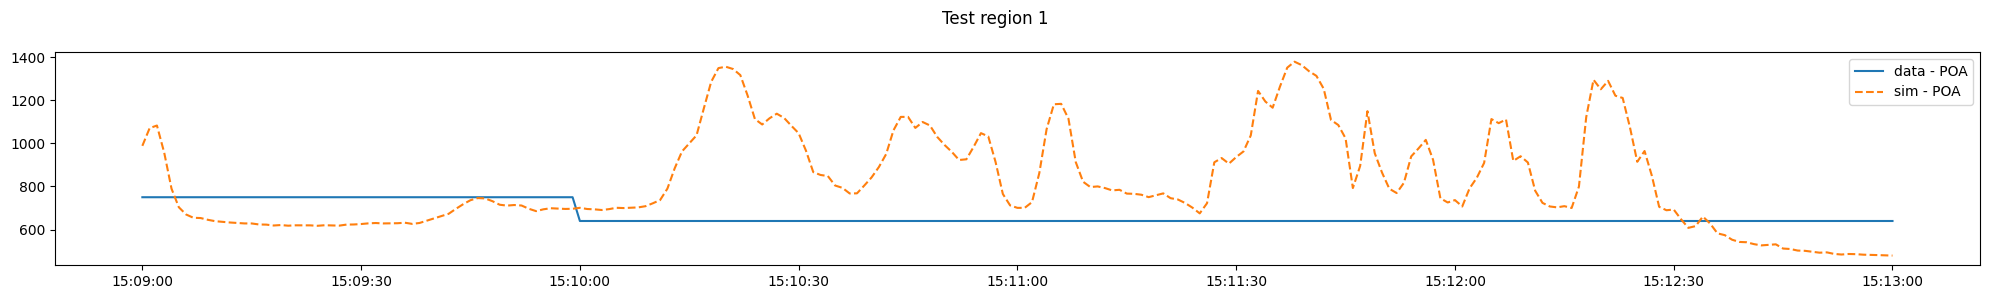

In [10]:
# POA
plt.figure(figsize=(20, 3))
plt.suptitle(name)
plt.plot(df_pred.index, df_pred["solcast_poa"], label="data - POA")
plt.plot(df_sim.index, df_sim["poa"], "--", label="sim - POA")
plt.tight_layout()
plt.legend()
plt.show()


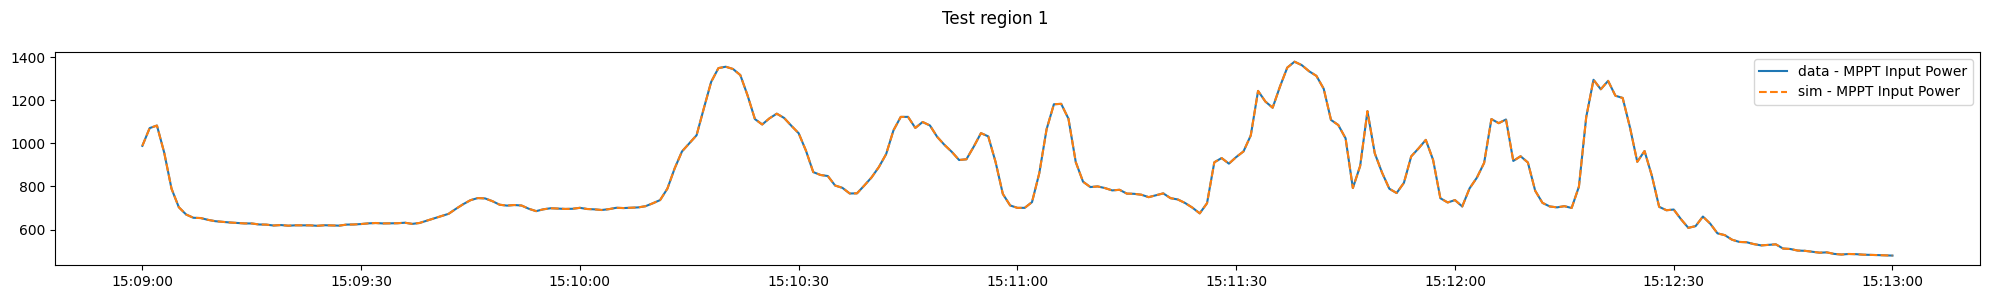

In [11]:
# MPPT PI
plt.figure(figsize=(20, 3))
plt.suptitle(name)
plt.plot(df_pred.index, df_pred["mppt_p_in"], label="data - MPPT Input Power")
plt.plot(df_sim.index, df_sim["mppt_input_power"], "--", label="sim - MPPT Input Power")
plt.tight_layout()
plt.legend()
plt.show()


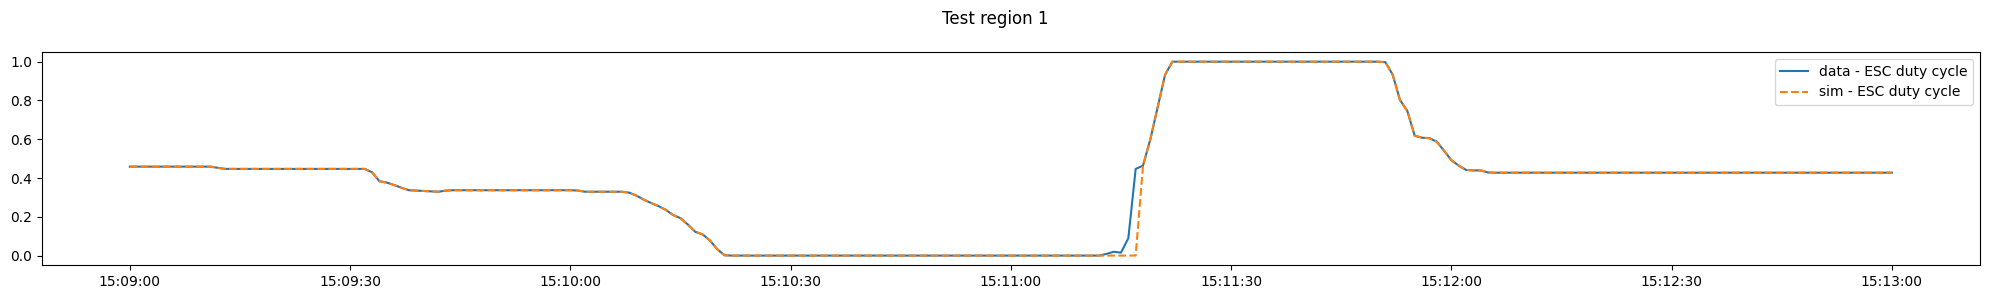

In [12]:
# ESC Duty cycle
plt.figure(figsize=(20, 3))
plt.suptitle(name)
plt.plot(df_pred.index, df_pred["esc_dt"], label="data - ESC duty-cycle")
plt.plot(df_sim.index, df_sim["motor_throttle"], "--", label="sim - ESC duty-cycle")
plt.tight_layout()
plt.legend()
plt.show()


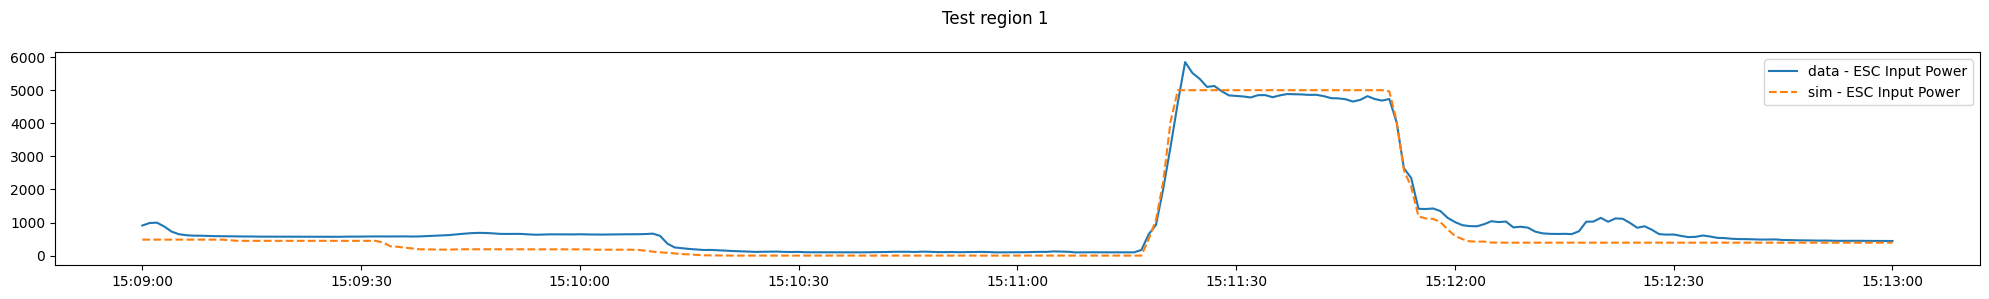

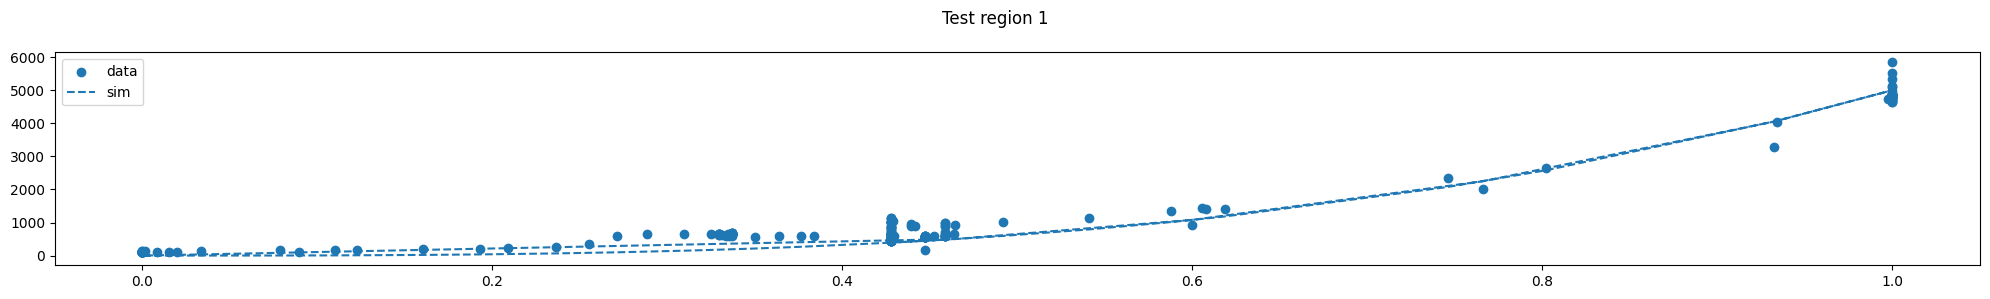

In [13]:
# ESC Input Power
plt.figure(figsize=(20, 3))
plt.suptitle(name)
plt.plot(df_pred.index, df_pred["esc_p_in"], label="data - ESC Input Power")
plt.plot(df_sim.index, df_sim["esc_input_power"], "--", label="sim - ESC Input Power")
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(20, 3))
plt.suptitle(name)
plt.scatter(df_pred["esc_dt"], df_pred["esc_p_in"], label="data")
plt.plot(df_sim["motor_throttle"], df_sim["esc_input_power"], "--", label="sim")
plt.tight_layout()
plt.legend()
plt.show()


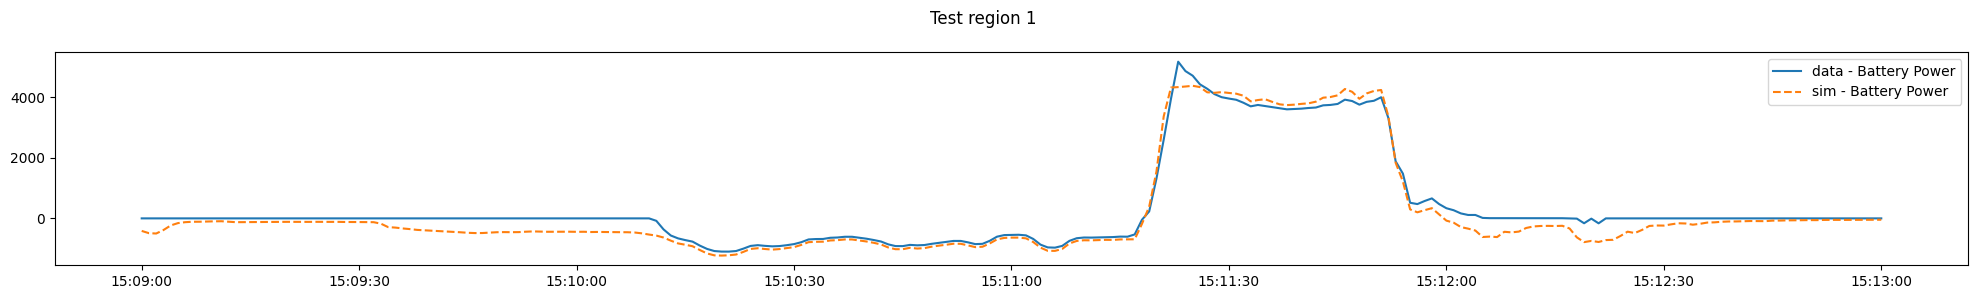

In [14]:
# BAT Output Power
plt.figure(figsize=(20, 3))
plt.suptitle(name)
plt.plot(df_pred.index, df_pred["batt_p"], label="data - Battery Power")
plt.plot(df_sim.index, -df_sim["battery_output_power"], "--", label="sim - Battery Power") # TODO: Fix sim model
plt.tight_layout()
plt.legend()
plt.show()


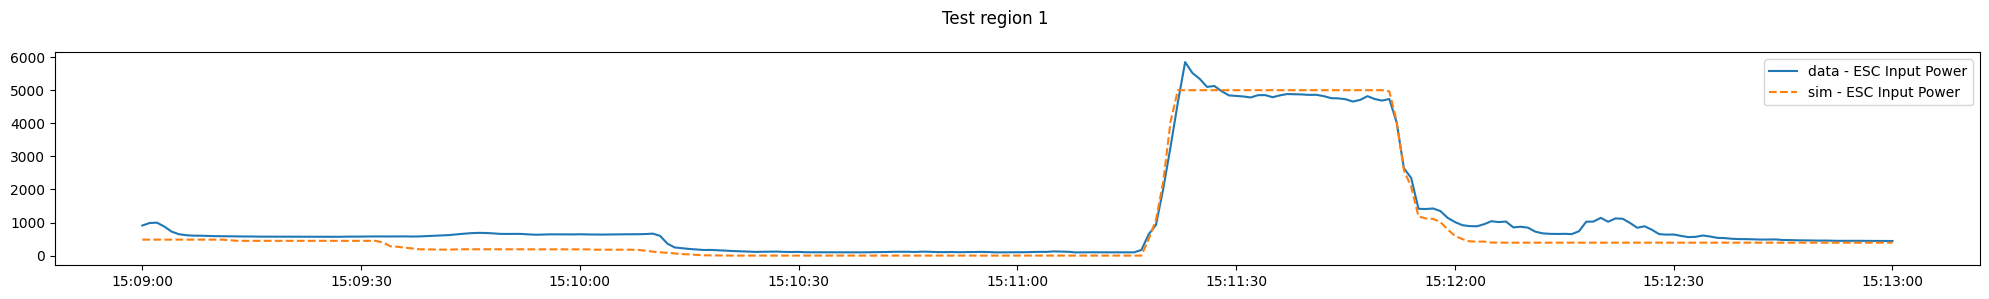

In [15]:
# ESC
plt.figure(figsize=(20, 3))
plt.suptitle(name)
plt.plot(df_pred.index, df_pred["esc_p_in"], label="data - ESC Input Power")
plt.plot(df_sim.index, df_sim["esc_input_power"], '--', label="sim - ESC Input Power")
plt.tight_layout()
plt.legend()
plt.show()


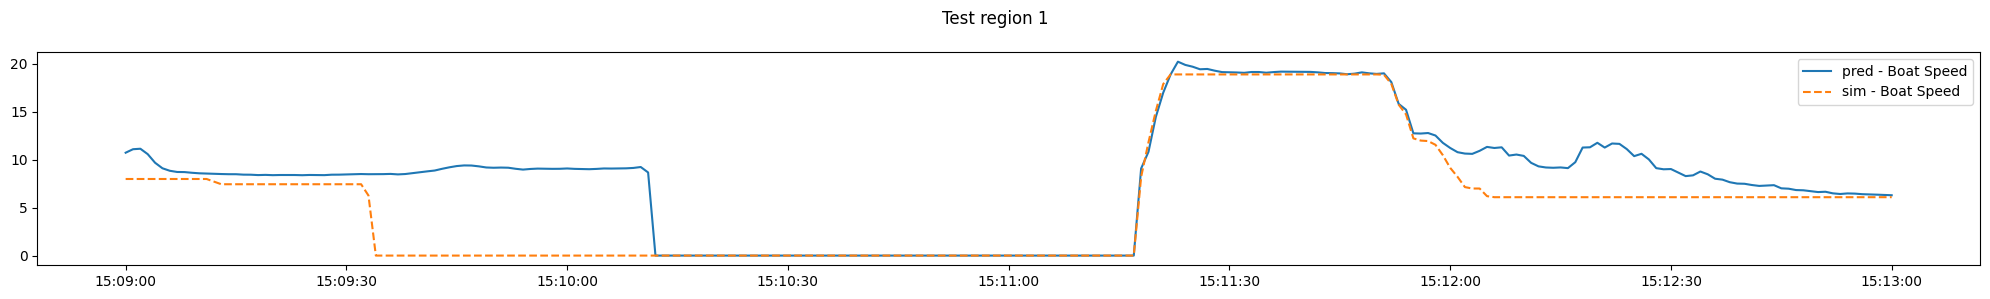

In [16]:
# Speed
plt.figure(figsize=(20, 3))
plt.suptitle(name)
plt.plot(df_pred.index, df_pred["pred_speed"], label="pred - Boat Speed")
plt.plot(df_pred.index, df_sim["hull_speed"], '--', label="sim - Boat Speed")

plt.tight_layout()
plt.legend()
plt.show()